In [ ]:
import math
import cv2 as cv
import numpy as np
from skimage.morphology import skeletonize as skelt
from google.colab.patches import cv2_imshow
import pandas as pd
from scipy.signal import convolve2d

In [ ]:
df = pd.DataFrame(columns=['x','y','theta','t'])

In [ ]:
def get_mask(im, w, threshold=.2):

    (y, x) = im.shape
    threshold = np.std(im)*threshold

    image_variance = np.zeros(im.shape)
    mask = np.ones_like(im)

    for i in range(0, x, w):
        for j in range(0, y, w):
            box = [i, j, min(i + w, x), min(j + w, y)]
            block_stddev = np.std(im[box[1]:box[3], box[0]:box[2]])
            image_variance[box[1]:box[3], box[0]:box[2]] = block_stddev

    # apply threshold
    mask[image_variance < threshold] = 0

    # smooth mask with a open/close morphological filter
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(w*2, w*2))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

    return mask

In [ ]:
def kernel_from_function(size, f):
    kernel = [[] for i in range(0, size)]
    for i in range(0, size):
        for j in range(0, size):
            kernel[i].append(f(i - size / 2, j - size / 2))
    return kernel


def gauss(x, y):
    ssigma = 1.0
    return (1 / (2 * math.pi * ssigma)) * math.exp(-(x * x + y * y) / (2 * ssigma))


def calculate_angles(im, W):

    j1 = lambda x, y: 2 * x * y
    j2 = lambda x, y: x ** 2 - y ** 2
    j3 = lambda x, y: x ** 2 + y ** 2

    (y, x) = im.shape

    sobelOperator = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    ySobel = np.array(sobelOperator).astype(int)
    xSobel = np.transpose(ySobel).astype(int)

    result = [[] for i in range(1, y, W)]

    Gx_ = cv.filter2D(im/125,-1, ySobel)*125
    Gy_ = cv.filter2D(im/125,-1, xSobel)*125

    for j in range(1, y, W):
        for i in range(1, x, W):
            nominator = 0
            denominator = 0
            for l in range(j, min(j + W, y - 1)):
                for k in range(i, min(i + W , x - 1)):
                    Gx = round(Gx_[l, k])  # horizontal gradients at l, k
                    Gy = round(Gy_[l, k])  # vertial gradients at l, k
                    nominator += j1(Gx, Gy)
                    denominator += j2(Gx, Gy)

            if nominator or denominator:
                angle = (math.pi + math.atan2(nominator, denominator)) / 2
                orientation = np.pi/2 + math.atan2(nominator,denominator)/2
                result[int((j-1) // W)].append(angle)
            else:
                result[int((j-1) // W)].append(0)


    result = np.array(result)

    return result

In [ ]:
def skeletonize(image_input):

    image = np.zeros_like(image_input)
    image[image_input == 0] = 1.0
    output = np.zeros_like(image_input)

    skeleton = skelt(image)

    output[skeleton] = 255
    cv.bitwise_not(output, output)

    return output

In [ ]:
import skimage.morphology
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square


def __removeSpuriousMinutiae(minutiaeList, img, thresh):#see in sp.text file for more detaile
        img = img * 0;
        SpuriousMin = [];
        numPoints = len(minutiaeList);
        D = np.zeros((numPoints, numPoints))
        for i in range(1,numPoints):
            for j in range(0, i):
                (X1,Y1) = minutiaeList[i]['centroid']
                (X2,Y2) = minutiaeList[j]['centroid']

                dist = np.sqrt((X2-X1)**2 + (Y2-Y1)**2);
                D[i][j] = dist
                if(dist < thresh):
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(0,numPoints):
            if(not i in SpuriousMin):
                (X,Y) = np.int16(minutiaeList[i]['centroid']);
                img[X,Y] = 1;

        img = np.uint8(img);
        return(img)


def __cleanMinutiae(img, minutiaeTerm):
        minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2);#Label connected regions of an integer array
        RP = skimage.measure.regionprops(minutiaeTerm)#Measure properties of labeled image regions.
        # print(RP[])
        minutiaeTerm = __removeSpuriousMinutiae(RP, np.uint8(img), 10);
        return minutiaeTerm

In [ ]:
def minutiae_at(pixels, i, j):

    # if middle pixel is black (represents ridge)
    if pixels[i][j] == 1:

        cells = [(-1, -1), (-1, 0), (-1, 1),            # p1 p2 p3
                   (0, 1),  (1, 1),  (1, 0),            # p8    p4
                  (1, -1), (0, -1), (-1, -1)]           # p7 p6 p5

        values = [pixels[i + l][j + k] for k, l in cells]

        # count crossing how many times it goes from 0 to 1
        crossings = 0
        for k in range(0, len(values)-1):
            crossings += abs(values[k] - values[k + 1])
        crossings //= 2

        # if pixel on boundary are crossed with the ridge once, then it is a possible ridge ending
        # if pixel on boundary are crossed with the ridge three times, then it is a ridge bifurcation
        if crossings == 1:
            return "ending"
        if crossings == 3:
            return "bifurcation"

    return "none"


# def calculate_minutiaes(im, orientations, kernel_size=3):
#     biniry_image = np.zeros_like(im)
#     biniry_image[im<10] = 1.0
#     biniry_image = biniry_image.astype(np.int8)

#     (y, x) = im.shape
#     result = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
#     colors = {"ending" : (150, 0, 0), "bifurcation" : (0, 150, 0)}

#     # iterate each pixel minutia
#     for i in range(1, x - kernel_size//2):
#         for j in range(1, y - kernel_size//2):
#             minutiae = minutiae_at(biniry_image, j, i, kernel_size)
#             if minutiae != "none":
#                 cv.circle(result, (i,j), radius=2, color=colors[minutiae], thickness=2)
#                 if minutiae == 'ending':
#                     df.loc[len(df.index)] = [j, i, orientations[j][i], 3]
#                 if minutiae == 'bifurcation':
#                     df.loc[len(df.index)] = [j, i, orientations[j][i], 4]

#     return result




def calculate_minutiaes(im, orientations, kernel_size=3):
    minutiaeTerm = np.zeros_like(im)
    minutiaeBif = np.zeros_like(im)

    biniry_image = np.zeros_like(im)
    biniry_image[im<10] = 1.0
    biniry_image = biniry_image.astype(np.int8)

    (y, x) = im.shape
    result = cv.cvtColor(im, cv.COLOR_GRAY2RGB)
    colors = {"ending" : (150, 0, 0), "bifurcation" : (0, 150, 0)}

    # iterate each pixel minutia
    for i in range(1, x - kernel_size//2):
        for j in range(1, y - kernel_size//2):
            minutiae = minutiae_at(biniry_image, j, i)
            if minutiae != "none":
                if minutiae == 'ending':
                    minutiaeTerm[j][i] = 1
                if minutiae == 'bifurcation':
                    minutiaeBif[j][i] = 1
                minutiaeTerm = __cleanMinutiae(im, minutiaeTerm)


    for i in range(1, x - kernel_size//2):
        for j in range(1, y - kernel_size//2):
            if minutiaeTerm[j][i] == 1:
              cv.circle(result, (i,j), radius=2, color=colors["ending"], thickness=2)
              df.loc[len(df.index)] = [j, i, orientations[j][i], 3]
            if minutiaeBif[j][i] == 1:
              cv.circle(result, (i,j), radius=2, color=colors["bifurcation"], thickness=2)
              df.loc[len(df.index)] = [j, i, orientations[j][i], 4]


    return result

In [ ]:
def poincare_index_at(i, j, angles, tolerance):

    cells = [(-1, -1), (-1, 0), (-1, 1),         # p1 p2 p3
            (0, 1),  (1, 1),  (1, 0),            # p8    p4
            (1, -1), (0, -1), (-1, -1)]          # p7 p6 p5

    angles_around_index = [math.degrees(angles[i - k][j - l]) for k, l in cells]
    index = 0
    for k in range(0, 8):

        # calculate the difference
        difference = angles_around_index[k] - angles_around_index[k + 1]
        if difference > 90:
            difference -= 180
        elif difference < -90:
            difference += 180

        index += difference

    if 180 - tolerance <= index <= 180 + tolerance:
        return "loop"
    if -180 - tolerance <= index <= -180 + tolerance:
        return "delta"
    if 360 - tolerance <= index <= 360 + tolerance:
        return "whorl"
    return "none"


def calculate_singularities(im, angles, tolerance, W, mask, orientations):
    result = cv.cvtColor(im, cv.COLOR_GRAY2RGB)

    # DELTA: RED, LOOP:ORAGNE, whorl:INK
    colors = {"loop" : (0, 0, 255), "delta" : (0, 128, 255), "whorl": (255, 153, 255)}

    for i in range(3, len(angles) - 2):             # Y
        for j in range(3, len(angles[i]) - 2):      # x
            # mask any singularity outside of the mask
            mask_slice = mask[(i-2)*W:(i+3)*W, (j-2)*W:(j+3)*W]
            mask_flag = np.sum(mask_slice)
            if mask_flag == (W*5)**2:
                singularity = poincare_index_at(i, j, angles, tolerance)
                if singularity != "none":
                    cv.rectangle(result, ((j+0)*W, (i+0)*W), ((j+1)*W, (i+1)*W), colors[singularity], 3)
                    if singularity == 'loop':
                      df.loc[len(df.index)] = [j*W, i*W, orientations[j*W][i*W], 1]
                    if singularity == 'delta':
                      df.loc[len(df.index)] = [j*W, i*W, orientations[j*W][i*W], -1]
                    if singularity == 'whorl':
                      df.loc[len(df.index)] = [j*W, i*W, orientations[j*W][i*W], 2]

    return result

In [ ]:
def _filter_custom(image: np.array,
                   krn: np.array):
    assert(krn.shape[0] == krn.shape[1])
    return convolve2d(image.astype(np.float32), krn, mode='same')

def _filter_sobel(image: np.array,
                  axis: str,
                  krnsize: int):
    assert(axis == 'x' or axis == 'y')
    if axis == 'x':
        return cv.Sobel(image.astype(np.float32), cv.CV_32F, 1, 0,
                        ksize=krnsize)
    elif axis == 'y':
        return cv.Sobel(image.astype(np.float32), cv.CV_32F, 0, 1,
                        ksize=krnsize)


def _filter_lowpass(image: np.array,
                    krnsize: int,
                    krnsigma: float):
    krn = cv.getGaussianKernel(krnsize, krnsigma)
    krn = krn * krn.T
    return _filter_custom(image, krn)


def filter(image: np.array,
           method: str=None,
           krnsize: int=11,
           krnsigma: int=2,
           krn: np.array=None):

    if method is None and krn is not None:
        return _filter_custom(image, krn)

    if method == 'lowpass':
        return _filter_lowpass(image, krnsize, krnsigma)
    elif method == 'sobelx':
        return _filter_sobel(image, 'x', krnsize)
    elif method == 'sobely':
        return _filter_sobel(image, 'y', krnsize)
    else:
        raise Exception(method + ' filtering method is not supported!')

def orientation(image: np.array,
                grdsigma: float,
                blksigma: float,
                smtsigma: float):

    # Find the basic gradients
    Gx = filter(image, 'sobelx', int(3 * grdsigma))
    Gy = filter(image, 'sobely', int(3 * grdsigma))

    # Smoothing
    Gxx = filter(Gx * Gx, 'lowpass', int(3 * blksigma), blksigma)
    Gyy = filter(Gy * Gy, 'lowpass', int(3 * blksigma), blksigma)
    Gxy = filter(Gx * Gy, 'lowpass', int(3 * blksigma), blksigma)

    sin = filter(2 * Gxy, 'lowpass', int(3 * smtsigma), smtsigma)
    cos = filter(Gxx - Gyy, 'lowpass', int(3 * smtsigma), smtsigma)

    # Clockwise rotation in radians
    orient = np.arctan2(sin, cos) / 2 + np.pi / 2
    return orient

In [ ]:
# orientations = orientation(img, grdsigma=3, blksigma=3, smtsigma=3)
# orientations.shape
# orientations[0][40:100]


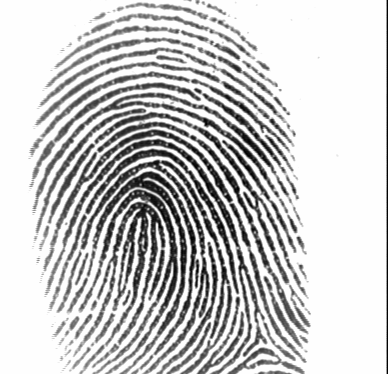

(374, 388)


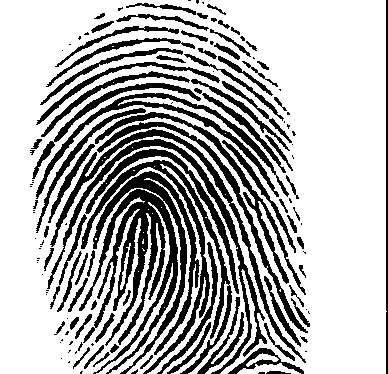

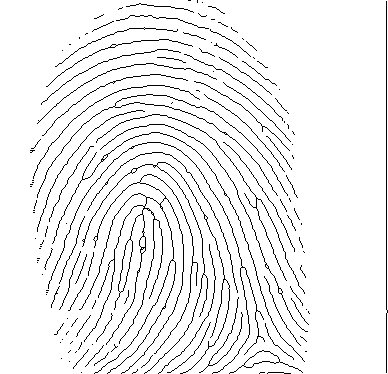

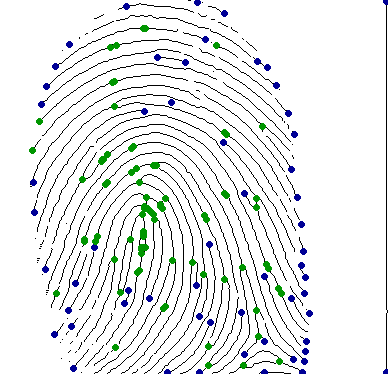

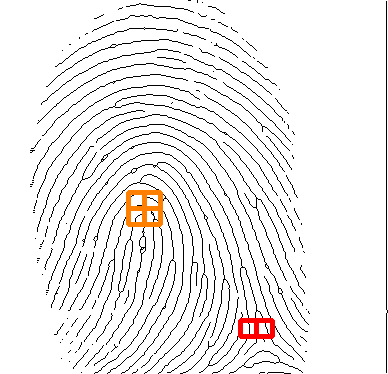

In [ ]:
# reading the image
img = cv.imread('102_6.tif', 0)
cv2_imshow(img)
print(img.shape)

W = 16

mask = get_mask(img, W, 0.2)

# orientations
orientations = orientation(img, grdsigma=3, blksigma=3, smtsigma=3)
angles = calculate_angles(img, W)
# print(angles.shape)

# binarization
th, im_th = cv.threshold(img, 170, 255, cv.THRESH_BINARY)
cv2_imshow(im_th)

# thinning or skeletonize
thin_image = skeletonize(im_th)
cv2_imshow(thin_image)
# print(thin_image.shape)

# minutias
minutias = calculate_minutiaes(thin_image, orientations)
cv2_imshow(minutias)

# singularities
result = calculate_singularities(thin_image, angles, 1, W, mask, orientations)
cv2_imshow(result)

In [ ]:
# loop  : 1
# delta : -1
# whorl : 2
# ending  : 3
# bifurcation : 4


# bifurcation
df[df["t"]==4]

,x,y,theta,t
0,150.0,32.0,2.008499,4.0
3,121.0,39.0,2.352664,4.0
9,293.0,56.0,1.905967,4.0
15,179.0,82.0,2.191305,4.0
16,239.0,84.0,1.819003,4.0
...,...,...,...,...
116,264.0,266.0,1.160311,4.0
118,268.0,268.0,1.090537,4.0
120,288.0,278.0,1.244763,4.0
121,361.0,279.0,0.226852,4.0


In [ ]:
# ending
df[df["t"]==3]

,x,y,theta,t
1,182.0,33.0,1.947235,3.0
2,212.0,34.0,1.845635,3.0
4,104.0,41.0,2.368064,3.0
5,269.0,45.0,1.886330,3.0
6,86.0,46.0,2.398760,3.0
7,334.0,54.0,2.183206,3.0
8,66.0,55.0,2.450224,3.0
10,310.0,68.0,2.029787,3.0
11,44.0,69.0,2.379352,3.0
12,326.0,71.0,2.073254,3.0


In [ ]:
# loop
df[df["t"]==1]

,x,y,theta,t
145,240.0,320.0,1.570796,1.0
146,256.0,320.0,1.570796,1.0


In [ ]:
# delta
df[df["t"]==-1]

,x,y,theta,t
141,128.0,192.0,0.458709,-1.0
142,144.0,192.0,0.597691,-1.0
143,128.0,208.0,0.462005,-1.0
144,144.0,208.0,0.706377,-1.0


In [ ]:
# whorl
df[df["t"]==2]

,x,y,theta,t


In [ ]:
df.to_csv("result.csv")